In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from numpy.random import seed
import tensorflow as tf

seed_value=2


In [4]:
import scipy.io
import pandas as pd
import numpy as np

In [5]:
def epoching(data,x):
    n=int(data.shape[1]/x)
    epoched_data=[]
    for i in range(n):
        epoched_data.append(data[:,x*i:x*(i+1)])
    epoched_data=np.array(epoched_data)
    return epoched_data

## Importing y_array

In [6]:
def create_y():
  y_array=np.load('gdrive/My Drive/Dissertation_files/word_list.npy')
  return y_array
  

## EXTRACTING ALPHA, BETA, GAMMA BANDS

In [7]:
pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 6.5 MB/s 


In [8]:
import mne

In [9]:
def visualise_data(data):
  sfreq = 128
  ch_names = ["F3","FC5","AF3","F7","T7","P7","O1","O2","P8","T8","F8","AF4","FC6","F4"]
  info = mne.create_info(ch_names = ch_names, sfreq = sfreq)
  raw = mne.io.RawArray(data, info)
  raw.plot()    ##Channel signals
  raw.plot_psd(tmax=np.inf, average=True,picks='all') ##PSD Curve

  return

In [11]:
def extract_bands(data):
  seed(seed_value)
  tf.random.set_seed(seed_value)

  continuous_data=[]
  trials=data.shape[0]
  channels=data.shape[1]
  sample_size=data.shape[2]
  for i in range(channels):
      continuous_data.append(data[:,i].reshape(trials*sample_size))
  continuous_data=np.array(continuous_data)

  # visualise_data(continuous_data)

  alpha_continuous=mne.filter.filter_data(continuous_data, 128, 8, 12)
  beta_continuous=mne.filter.filter_data(continuous_data, 128, 12, 30)
  gamma_continuous=mne.filter.filter_data(continuous_data, 128, 30, 50)

  x=sample_size

  alpha_epoched=epoching(alpha_continuous,x)
  beta_epoched=epoching(beta_continuous,x)
  gamma_epoched=epoching(gamma_continuous,x)

  return alpha_epoched,beta_epoched,gamma_epoched

## Feature Extraction 1

In [12]:
from pywt import wavedec
from sklearn.preprocessing import StandardScaler

In [13]:
def calc_features(arr):
    rms = np.sqrt(np.mean(arr**2,axis=2))
    var = np.var(arr, axis=2)
    kur = scipy.stats.kurtosis(arr, axis=2)
    skew = scipy.stats.skew(arr, axis=2)
    moment = scipy.stats.moment(arr, moment=3, axis=2)
    
    res=np.concatenate((rms,var,kur,skew,moment),axis=1)
    
    return res


    

In [14]:
def extract_features_dwt(data):
  seed(seed_value)
  tf.random.set_seed(seed_value)
  
  coeffs=wavedec(data, 'db2', level=3)
  coeffs.append(data)
  res=[]
  for arr in coeffs:
    res.append(calc_features(arr))
  x_array=np.concatenate((res[0],res[1],res[2],res[3],res[4]),axis=1)
  
  scaler = StandardScaler()
  scaler.fit(x_array)
  x_array = scaler.transform(x_array)

  return x_array

## Feature Extraction 2

In [15]:
from scipy.signal import hilbert
from scipy.signal import welch
from scipy.signal import csd,coherence

In [16]:
def msc(arr1,arr2):
    msc=coherence(arr1,arr2,fs=128,window="hamm",nperseg=8)[1]
    return np.mean(msc)

In [17]:
def mpc(arr1,arr2):
    imag_1=np.imag(hilbert(arr1))  #Imaginary part of hilbert transform
    imag_2=np.imag(hilbert(arr2))
    phase_1=np.arctan(imag_1/arr1)  #Real part is equal to actual array values
    phase_2=np.arctan(imag_2/arr2)
    phase_diff=(phase_1-phase_2)
    mpc=np.linalg.norm(np.sum(np.exp(1j*phase_diff)))/len(arr1)
    return mpc

In [18]:
def extract_features_coherence(data):
  alpha_epoched,beta_epoched,gamma_epoched=extract_bands(data)

  n=alpha_epoched.shape[0]
  m=alpha_epoched.shape[1]
  l=alpha_epoched.shape[2]

  mpc_alpha=np.zeros([n,m,m])
  mpc_beta=np.zeros([n,m,m])
  mpc_gamma=np.zeros([n,m,m])

  msc_alpha=np.zeros([n,m,m])
  msc_beta=np.zeros([n,m,m])
  msc_gamma=np.zeros([n,m,m])

  #Calculating MPC and MSC
  for i in range(n):
    for j in range(m):
        for k in range(m):
            
            mpc_alpha[i][j][k]=mpc(alpha_epoched[i][j],alpha_epoched[i][k])
            msc_alpha[i][j][k]=msc(alpha_epoched[i][j],alpha_epoched[i][k])
            
            mpc_beta[i][j][k]=mpc(beta_epoched[i][j],beta_epoched[i][k])
            msc_beta[i][j][k]=msc(beta_epoched[i][j],beta_epoched[i][k])
            
            mpc_gamma[i][j][k]=mpc(gamma_epoched[i][j],gamma_epoched[i][k])
            msc_gamma[i][j][k]=msc(gamma_epoched[i][j],gamma_epoched[i][k])

    # if i%50==0:   
    #   print(i,end=" ")

  x_array=np.zeros([n,m,m,3])

  #Creating 3D array for CNN
  for i in range(n):
    for j in range(m):
        for k in range(m):
            if j<k:
                x_array[i][j][k]=[mpc_alpha[i][j][k],mpc_beta[i][j][k],mpc_gamma[i][j][k]]
            elif j>k:
                x_array[i][j][k]=[msc_alpha[i][j][k],msc_beta[i][j][k],msc_gamma[i][j][k]] 

  # x_array_cnn=x_array

  #Creating 1D array for ML
  a=x_array.reshape(n,m*m*3)
  a=a[a!=0.0]
  x_array=a.reshape(n,m*m*3-m*3) 

  return x_array

## Loading word pairs based on distance metrics

In [19]:
import pickle

In [20]:
num_dict={0:'date',1:'goose',2:'spruce',3:'knight',4:'juice',5:'moose',6:'night',7:'queen',8:'berry',
          9:'hedgehog',10:'water',11:'daughter',12:'gooseberry',13:'waterfowl',14:'wilderness',
          15:'relative',16:'watermelon',17:'caterpillar',18:'environment',19:'ambassador'}

In [21]:
def pairs():
  complete_pairs={}
  x=np.arange(20)
  for i in range(20):
      complete_pairs[i]=list(x[x!=i])

  long_pairs={}
  x=np.arange(12,20)
  for i in range(12,20):
      long_pairs[i]=list(x[x!=i])

  short_pairs={}
  x=np.arange(12)
  for i in range(12):
      short_pairs[i]=list(x[x!=i])

  with open('gdrive/My Drive/Dissertation_files/levenshtein_pairs.pickle', "rb") as file:
    levenshtein_pairs = pickle.load(file)

  with open('gdrive/My Drive/Dissertation_files/word2vec_pairs.pickle', "rb") as file:
    word2vec_pairs = pickle.load(file)

  with open('gdrive/My Drive/Dissertation_files/phonetic_pairs.pickle', "rb") as file:
    phonetic_pairs = pickle.load(file)
  
  with open('gdrive/My Drive/Dissertation_files/neuro_pairs.pickle', "rb") as file:
    neuro_pairs = pickle.load(file)

  with open('gdrive/My Drive/Dissertation_files/acoustic_pairs.pickle', "rb") as file:
    acoustic_pairs = pickle.load(file)  
  
  return [complete_pairs,long_pairs,short_pairs,levenshtein_pairs,word2vec_pairs,phonetic_pairs,neuro_pairs,acoustic_pairs]

## Calculating results

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [85]:
def model_rf(x_train,y_train,x_test,y_test):
    seed(seed_value)
    tf.random.set_seed(seed_value)

    random = RandomForestClassifier()
    distributions = dict(max_depth=[4,5,6],n_estimators=[10,15],criterion=['gini'])
    clf = GridSearchCV(random, distributions,cv=5)
    clf.fit(x_train,y_train)

    a=clf.best_params_
    clf = RandomForestClassifier(max_depth=a["max_depth"],n_estimators=a['n_estimators'],
                                 criterion=a['criterion'])
    train_scores = cross_val_score(clf, x_train, y_train, cv=5, scoring='f1_macro')
    train_acc=np.mean(train_scores)
    test_scores = cross_val_score(clf, x_test, y_test, cv=5, scoring='f1_macro')
    test_acc=np.mean(test_scores)

    return train_acc,test_acc

In [86]:
def model_svm(x_train,y_train,x_test,y_test):
    seed(seed_value)
    tf.random.set_seed(seed_value)

    model=svm.SVC()
    distributions = dict(kernel=['sigmoid'],C=[0.9,1])  #C is optimised
    clf = GridSearchCV(model, distributions,cv=StratifiedKFold(n_splits=5, shuffle=False))
    clf.fit(x_train,y_train)

    a=clf.best_params_
    clf = svm.SVC(kernel=a["kernel"],C=a["C"])
    train_scores = cross_val_score(clf, x_train, y_train, cv=5, scoring='f1_macro')
    train_acc=np.mean(train_scores)
    test_scores = cross_val_score(clf, x_test, y_test, cv=5, scoring='f1_macro')
    test_acc=np.mean(test_scores)  

    return train_acc,test_acc


In [25]:
def get_arrays(a,b,x_array,y_array):
    seed(seed_value)
    tf.random.set_seed(seed_value)

    index=np.where((y_array==a) | (y_array==b))
    x=x_array[index]
    y=y_array[index]
    if b==0:
      y[y==a]=1
      y[y==b]=0
    else:
      y[y==a]=0
      y[y==b]=1 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15,shuffle=False)
    return x_train, x_test, y_train, y_test

In [26]:
def calculate_results(dict1,x_array,y_array): 
    for i in dict1.keys():
        n=len(dict1[i])
        break                                          # n=Number of words to calculate acccuracy for each root word
    rf_test=np.zeros([len(dict1.keys()),n])
    rf_train=np.zeros([len(dict1.keys()),n])
    svm_test=np.zeros([len(dict1.keys()),n])
    svm_train=np.zeros([len(dict1.keys()),n])
    cnn_test=np.zeros([len(dict1.keys()),n])
    cnn_train=np.zeros([len(dict1.keys()),n])
    word_list=[]
    for i,word_index in enumerate(dict1.keys()):
        words=[]
        for j in range(len(dict1[word_index])):
            words.append(num_dict[dict1[word_index][j]])  
            x_train, x_test, y_train, y_test=get_arrays(word_index,dict1[word_index][j],x_array,y_array)
            train_acc,test_acc=model_rf(x_train, y_train, x_test, y_test)
            rf_test[i][j]=round(test_acc*100,2) 
            rf_train[i][j]=round(train_acc*100,2)
            train_acc,test_acc=model_svm(x_train, y_train, x_test, y_test)
            svm_test[i][j]=round(test_acc*100,2)
            svm_train[i][j]=round(train_acc*100,2)
            train_acc,test_acc=model_cnn(x_train, y_train, x_test, y_test)
            cnn_test[i][j]=round(test_acc*100,2)
            cnn_train[i][j]=round(train_acc*100,2)
        word_list.append(words)
    
    return rf_test,rf_train,svm_test,svm_train,cnn_test,cnn_train

        
        

In [27]:
def multi_class_svm(x,y):
    seed(seed_value)
    tf.random.set_seed(seed_value)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=0,shuffle=False)
    model=svm.SVC()
    distributions = dict(kernel=['sigmoid'],C=[0.9,1])  #C is optimised
    clf = GridSearchCV(model, distributions,cv=StratifiedKFold(n_splits=5))
    clf.fit(x_train,y_train)

    a=clf.best_params_
    clf = svm.SVC(kernel=a["kernel"],C=a["C"])
    train_scores = cross_val_score(clf, x_train, y_train, cv=5, scoring='f1_macro')
    train_acc=np.mean(train_scores)
    test_scores = cross_val_score(clf, x_test, y_test, cv=5, scoring='f1_macro')
    test_acc=np.mean(test_scores) 

    # a=np.std(test_scores)
    # return round(a*100,2)
  
    return train_acc,test_acc
    

In [77]:
def multi_class_rf(x,y):
    seed(seed_value)
    tf.random.set_seed(seed_value)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=0,shuffle=False)
    random = RandomForestClassifier()
    distributions = dict(max_depth=[4,5,6],n_estimators=[10,15],criterion=['gini'])
    clf = GridSearchCV(random, distributions,cv=StratifiedKFold(n_splits=5))
    clf.fit(x_train,y_train)

    a=clf.best_params_
    clf = RandomForestClassifier(max_depth=a["max_depth"],n_estimators=a['n_estimators'],
                                 criterion=a['criterion'])
    train_scores = cross_val_score(clf, x_train, y_train, cv=5, scoring='f1_macro')
    train_acc=np.mean(train_scores)
    test_scores = cross_val_score(clf, x_test, y_test, cv=5, scoring='f1_macro')
    test_acc=np.mean(test_scores)

    # a=np.std(test_scores)
    # return round(a*100,2)

    return train_acc,test_acc

In [29]:
import keras
import tensorflow as tf
from keras import Sequential
from keras.losses import SparseCategoricalCrossentropy
from keras.layers.core import Activation,Dense,Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD



def create_model(m,n):
  seed(seed_value)
  tf.random.set_seed(seed_value)

  model = Sequential()


  model.add(Dense(64, input_dim=m,kernel_initializer='random_normal',bias_initializer='zeros'))
  model.add(BatchNormalization())
  model.add(Activation('tanh'))

  model.add(Dense(64,kernel_initializer='random_normal',bias_initializer='zeros'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Dense(n,kernel_initializer='random_normal',bias_initializer='zeros'))
  model.add(BatchNormalization())
  model.add(Activation('softmax'))
  
  return model

  

In [30]:
# plot_model(create_model(278,20),show_shapes=True,show_layer_names=True)

In [84]:
def model_cnn(x_train,y_train,x_test,y_test):
    seed(seed_value)
    tf.random.set_seed(seed_value)

    m=x_train.shape[1]
    n=len(np.unique(y_train))
    model=create_model(m,n)

    opt = SGD(learning_rate=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    loss_fn = SparseCategoricalCrossentropy()
    model.compile(loss=loss_fn, optimizer=opt,metrics=["accuracy"])

    model.fit(x_train, y_train, epochs=30, batch_size=16, validation_split=0.2,verbose = 0)

    score, test_acc = model.evaluate(x_test, y_test, verbose=0)
    score, train_acc = model.evaluate(x_train, y_train, verbose=0)


    return train_acc,test_acc



In [83]:

def multi_class_cnn(x,y):
  seed(seed_value)
  tf.random.set_seed(seed_value)
  
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15,shuffle=False)


  m=x.shape[1]
  n=len(np.unique(y))
  model=create_model(m,n)


  sgd = SGD(learning_rate=0.1, decay=1e-6, momentum=0.9, nesterov=True)
  loss_fn = SparseCategoricalCrossentropy()
  model.compile(loss=loss_fn, optimizer=sgd,metrics=["accuracy"])

  model.fit(x_train, y_train, epochs=30, batch_size=16, validation_split=0.2,verbose = 0)

  score, test_acc = model.evaluate(x_test, y_test, verbose=0)
  score, train_acc = model.evaluate(x_train, y_train, verbose=0)

  return train_acc,test_acc

## Calculating accuracies

In [33]:
def epoching(data,x):
    n=int(data.shape[1]/x)
    epoched_data=[]
    for i in range(n):
        epoched_data.append(data[:,x*i:x*(i+1)])
    epoched_data=np.array(epoched_data)
    return epoched_data

In [34]:
def other_pairs_acc(rf_test,rf_train,svm_test,svm_train,cnn_test,cnn_train,complete_pairs,pair_list):
  print(complete_pairs)
  print(len(pair_list))
  rf_test_list=[]
  rf_train_list=[]
  svm_test_list=[]
  svm_train_list=[]
  cnn_test_list=[]
  cnn_train_list=[]
  for num,pairs in enumerate(pair_list):
      m=len(pairs.keys())
      if num>1:
          n=6
      else:
          n=m-1
      rf_test_=np.zeros([m,n])
      rf_train_=np.zeros([m,n])
      svm_test_=np.zeros([m,n])
      svm_train_=np.zeros([m,n])
      cnn_test_=np.zeros([m,n])
      cnn_train_=np.zeros([m,n])
      for i,key in enumerate(pairs.keys()):
          for j,value in enumerate(pairs[key]):
              rf_test_[i][j]=rf_test[key][complete_pairs[key].index(value)]
              rf_train_[i][j]=rf_train[key][complete_pairs[key].index(value)]
              svm_test_[i][j]=svm_test[key][complete_pairs[key].index(value)]
              svm_train_[i][j]=svm_train[key][complete_pairs[key].index(value)]
              cnn_test_[i][j]=cnn_test[key][complete_pairs[key].index(value)]
              cnn_train_[i][j]=cnn_train[key][complete_pairs[key].index(value)]
      
      rf_test_list.append(rf_test_)
      rf_train_list.append(rf_train_)
      svm_test_list.append(svm_test_)
      svm_train_list.append(svm_train_)
      cnn_test_list.append(cnn_test_)
      cnn_train_list.append(cnn_train_)

  return rf_test_list,rf_train_list,svm_test_list,svm_train_list,cnn_test_list,cnn_train_list



In [35]:
def multi(x_array,y_array):
  order=["rf_test_complete","svm_test_complete","cnn_test_complete","rf_test_long",
         "svm_test_long","cnn_test_long","rf_test_short","svm_test_short","cnn_test_short"]
  
  seed(seed_value)
  tf.random.set_seed(seed_value)

  a=round(multi_class_rf(x_array,y_array)[1],2)
  b=round(multi_class_svm(x_array,y_array)[1],2)
  c=round(multi_class_cnn(x_array,y_array)[1],2)
  
  p=np.in1d(y_array,list(range(12,20)))
  x_array_lo=x_array[p]
  y_array_lo=y_array[p]
  for i,key in enumerate(np.unique(y_array_lo)):
    y_array_lo[y_array_lo==key]=i


  d=round(multi_class_rf(x_array_lo,y_array_lo)[1],2)
  e=round(multi_class_svm(x_array_lo,y_array_lo)[1],2)
  f=round(multi_class_cnn(x_array_lo,y_array_lo)[1],2)


  p=np.in1d(y_array,list(range(12)))
  x_array_sh=x_array[p]
  y_array_sh=y_array[p]
  for i,key in enumerate(np.unique(y_array_sh)):
    y_array_sh[y_array_sh==key]=i

  g=round(multi_class_rf(x_array_sh,y_array_sh)[1],2)
  h=round(multi_class_svm(x_array_sh,y_array_sh)[1],2)
  i=round(multi_class_cnn(x_array_sh,y_array_sh)[1],2)

  return [a,b,c,d,e,f,g,h,i]



In [36]:
def metric_score(arr):
  arr=np.array(arr)
  a=round((np.mean(arr[:,3:])-np.mean(arr[:,:3])),2)
  return a

In [37]:
from sklearn.decomposition import PCA
def pca(x_array):
  pca = PCA(.98)
  pca.fit(x_array)
  x_array = pca.transform(x_array)
  return x_array

In [38]:
def shuffle(x,y):
  p = np.random.RandomState(seed=0).permutation(len(y))
  x=x[p]
  y=y[p]
  return x,y

In [39]:
def main(df):

  seed(seed_value)
  tf.random.set_seed(seed_value)

  data=np.array(df)
  data=data.transpose()
  x=int(data.shape[1]/1000)

  epoched_data=epoching(data,x)

  y_array=create_y()

  x_array_1=extract_features_dwt(epoched_data)
  x_array_1=pca(x_array_1)
  x_array_1,y_array_1=shuffle(x_array_1,y_array)

  # with open('gdrive/My Drive/Dissertation_arrays/'+participant+"_"+speech_type+"_X1", 'wb') as file:
  #   pickle.dump([x_array_1,y_array_1], file, protocol=pickle.HIGHEST_PROTOCOL)


  x_array_2=extract_features_coherence(epoched_data)
  x_array_2=pca(x_array_2)
  x_array_2,y_array_2=shuffle(x_array_2,y_array)
  print("done")

  # with open('gdrive/My Drive/Dissertation_arrays/'+participant+"_"+speech_type+"_X2", 'wb') as file:
  #   pickle.dump([x_array_2,y_array_2], file, protocol=pickle.HIGHEST_PROTOCOL)

  pair_list=pairs()

  rf_test_1,rf_train_1,svm_test_1,svm_train_1,cnn_test_1,cnn_train_1=calculate_results(pair_list[0],x_array_1,y_array_1)
  print("done")

  rf_test_2,rf_train_2,svm_test_2,svm_train_2,cnn_test_2,cnn_train_2=calculate_results(pair_list[0],x_array_2,y_array_2)
  print("done")

  rf_test_list_1,rf_train_list_1,svm_test_list_1,svm_train_list_1,cnn_test_list_1,cnn_train_list_1=other_pairs_acc(rf_test_1,rf_train_1,svm_test_1,svm_train_1,cnn_test_1,cnn_train_1,pair_list[0],pair_list[1:])

  rf_test_list_2,rf_train_list_2,svm_test_list_2,svm_train_list_2,cnn_test_list_2,cnn_train_list_2=other_pairs_acc(rf_test_2,rf_train_2,svm_test_2,svm_train_2,cnn_test_2,cnn_train_2,pair_list[0],pair_list[1:])
                                                                                                                 

  #Adding accuracies of complete pairs for feature extraction 1  
  rf_test_list_1.append(rf_test_1)
  rf_train_list_1.append(rf_train_1)
  svm_test_list_1.append(svm_test_1)
  svm_train_list_1.append(svm_train_1)
  cnn_test_list_1.append(cnn_test_1)
  cnn_train_list_1.append(cnn_train_1)

  # Adding accuracies of complete pairs for feature extraction 2
  rf_test_list_2.append(rf_test_2)
  rf_train_list_2.append(rf_train_2)
  svm_test_list_2.append(svm_test_2)
  svm_train_list_2.append(svm_train_2)
  cnn_test_list_2.append(cnn_test_2)
  cnn_train_list_2.append(cnn_train_2)

  test_acc_list_1=[rf_test_list_1,svm_test_list_1,cnn_test_list_1]
  train_acc_list_1=[rf_train_list_1,svm_train_list_1,cnn_train_list_1]

  # with open('gdrive/My Drive/Dissertation_results/'+participant+"_"+speech_type+"/test_acc_list_1", 'wb') as file:
  #   pickle.dump(test_acc_list_1, file, protocol=pickle.HIGHEST_PROTOCOL)

  test_acc_list_2=[rf_test_list_2,svm_test_list_2,cnn_test_list_2]
  train_acc_list_2=[rf_train_list_2,svm_train_list_2,cnn_train_list_2]

  # with open('gdrive/My Drive/Dissertation_results/'+participant+"_"+speech_type+"/test_acc_list_2", 'wb') as file:
  #     pickle.dump(test_acc_list_2, file, protocol=pickle.HIGHEST_PROTOCOL)

  multi_class_1=multi(x_array_1,y_array_1)
  multi_class_2=multi(x_array_2,y_array_2)
  print(multi_class_1)
  print(multi_class_2)

  return test_acc_list_1,train_acc_list_1,test_acc_list_2,train_acc_list_2,multi_class_1,multi_class_2




In [40]:
binary_order=["all_words_mean_rf","all_words_sd_rf","all_words_mean_svm","all_words_sd_svm","all_words_mean_cnn","all_words_sd_cnn","long_words_mean_rf",
       "long_words_sd_rf","long_words_mean_svm","long_words_sd_svm","long_words_mean_cnn","long_words_sd_cnn",
       "short_words_mean_rf","short_words_sd_rf","short_words_mean_svm","short_words_sd_svm","short_words_mean_cnn","short_words_sd_cnn",
       "levenshtein_diff_rf","levenshtein_diff_svm","levenshtein_diff_cnn","word2vec_diff_rf","word2vec_diff_svm","word2vec_diff_cnn",
       "phonetic_distance_rf","phonetic_distance_svm","phonetic_distance_cnn","neuro_diff_rf","neuro_diff_svm","neuro_diff_cnn","acoustic_diff_rf",
       "acoustic_diff_svm","acoustic_diff_cnn"]

multi_order=["rf_test_complete","svm_test_complete","cnn_test_complete","rf_test_long",
         "svm_test_long","cnn_test_long","rf_test_short","svm_test_short","cnn_test_short"]



pair_list_order="[long_pairs,short_pairs,levenshtein_pairs,word2vec_pairs,phonetic_pairs,neuro_pairs,acoustic_pairs,complete_pairs]"


def save(participant,speech_type,test_acc_list_1,test_acc_list_2,multi_class_1,multi_class_2):
  results_binary_1=[]
  results_binary_2=[]
  results_multi_1=multi_class_1
  results_multi_2=multi_class_2


  for i in [-1,0,1]:
    for j in range(3):
      results_binary_1.append(round(np.mean(test_acc_list_1[j][i]),2))
      results_binary_1.append(round(np.std(test_acc_list_1[j][i]),2))
      results_binary_2.append(round(np.mean(test_acc_list_2[j][i]),2))
      results_binary_2.append(round(np.std(test_acc_list_2[j][i]),2))

  for i in range(2,7):
    for j in range(3):
      results_binary_1.append(metric_score(test_acc_list_1[j][i]))
      results_binary_2.append(metric_score(test_acc_list_2[j][i]))


  with open('gdrive/My Drive/Dissertation_results/'+participant+"_"+speech_type+"/results_binary_1", 'wb') as file:
      pickle.dump(results_binary_1, file, protocol=pickle.HIGHEST_PROTOCOL)


  with open('gdrive/My Drive/Dissertation_results/'+participant+"_"+speech_type+"/results_multi_1", 'wb') as file:
      pickle.dump(results_multi_1, file, protocol=pickle.HIGHEST_PROTOCOL)


  with open('gdrive/My Drive/Dissertation_results/'+participant+"_"+speech_type+"/results_binary_2", 'wb') as file:
      pickle.dump(results_binary_2, file, protocol=pickle.HIGHEST_PROTOCOL)


  with open('gdrive/My Drive/Dissertation_results/'+participant+"_"+speech_type+"/results_multi_2", 'wb') as file:
      pickle.dump(results_multi_2, file, protocol=pickle.HIGHEST_PROTOCOL)

  return



Calling main for all participants

In [42]:
participants=["01","02","03","04","05","06","07","08"]
speech_types=["imagined","inner"]

for participant in participants:
  for speech_type in speech_types:
    df=pd.read_csv('gdrive/My Drive/Dissertation_files/'+participant+'_'+speech_type+'_'+"final")
    df.drop(["Time"],axis=1,inplace=True)

    test_acc_list_1,train_acc_list_1,test_acc_list_2,train_acc_list_2,multi_class_1,multi_class_2=main(df)

    save(participant,speech_type,test_acc_list_1,test_acc_list_2,multi_class_1,multi_class_2)

    print(participant+"_"+speech_type+"_results saved")





In [44]:
import pickle

In [45]:
def load(participant,speech_type):
    with open('gdrive/My Drive/Dissertation_results/'+participant+"_"+speech_type+"/results_binary_1", 'rb') as file:
        results_binary_1 = pickle.load(file)

    with open('gdrive/My Drive/Dissertation_results/'+participant+"_"+speech_type+"/results_multi_1", 'rb') as file:
        results_multi_1 = pickle.load(file)


    with open('gdrive/My Drive/Dissertation_results/'+participant+"_"+speech_type+"/results_binary_2", 'rb') as file:
        results_binary_2 = pickle.load(file)


    with open('gdrive/My Drive/Dissertation_results/'+participant+"_"+speech_type+"/results_multi_2", 'rb') as file:
        results_multi_2 = pickle.load(file)
  
    return [results_binary_1,results_binary_2,results_multi_1,results_multi_2]



Imagined speech plots

In [48]:
results_binary_1_list=[]
results_binary_2_list=[]
results_multi_l_list=[]
results_multi_2_list=[]

participants=["01","02","03","04","05","06","07","08"]
speech_types=["imagined"]
for participant in participants:
  for speech_type in speech_types:
    arr=load(participant,speech_type)
    results_binary_1_list.append(arr[0])
    results_binary_2_list.append(arr[1])
    results_multi_l_list.append(arr[2])
    results_multi_2_list.append(arr[3])

results_binary_1_list=np.array(results_binary_1_list)
results_binary_2_list=np.array(results_binary_2_list)
results_multi_l_list=np.array(results_multi_l_list)
results_multi_2_list=np.array(results_multi_2_list)


In [49]:
leven_distance_2_ann=results_binary_2_list[:,19]
word2vec_distance_2_ann=results_binary_2_list[:,22]
phonetic_distance_2_ann=results_binary_2_list[:,25]
neuro_distance_2_ann=results_binary_2_list[:,28]
acoustic_distance_2_ann=results_binary_2_list[:,31]

In [50]:
leven_distance_2_rf=results_binary_2_list[:,17]
word2vec_distance_2_rf=results_binary_2_list[:,20]
phonetic_distance_2_rf=results_binary_2_list[:,23]
neuro_distance_2_rf=results_binary_2_list[:,26]
acoustic_distance_2_rf=results_binary_2_list[:,29]

In [51]:
leven_distance_2_svm=results_binary_2_list[:,18]
word2vec_distance_2_svm=results_binary_2_list[:,21]
phonetic_distance_2_svm=results_binary_2_list[:,24]
neuro_distance_2_svm=results_binary_2_list[:,27]
acoustic_distance_2_svm=results_binary_2_list[:,30]

In [52]:
binary_all_words_mean_1_rf=results_binary_1_list[:,0]
binary_all_words_mean_1_svm=results_binary_1_list[:,2]
binary_all_words_mean_1_cnn=results_binary_1_list[:,4]

binary_all_words_std_1_rf=results_binary_1_list[:,1]
binary_all_words_std_1_svm=results_binary_1_list[:,3]
binary_all_words_std_1_cnn=results_binary_1_list[:,5]


multi_all_words_mean_1_rf=results_multi_l_list[:,0]*100
multi_all_words_mean_1_svm=results_multi_l_list[:,1]*100
multi_all_words_mean_1_cnn=results_multi_l_list[:,2]*100

multi_all_words_std_1_rf=[2.05, 1.03, 1.34, 1.59, 0.56, 1.18, 1.74, 1.12]
multi_all_words_std_1_svm=[0.54, 0.58, 2.11, 0.14, 0.96, 1.65, 1.14, 1.42]
multi_all_words_std_1_cnn=[1.28, 1.19, 1.75, 1.29, 2.61, 1.41, 1.13, 1.47]

multi_long_words_mean_1_rf=results_multi_l_list[:,3]*100
multi_long_words_mean_1_svm=results_multi_l_list[:,4]*100
multi_long_words_mean_1_cnn=results_multi_l_list[:,5]*100

multi_long_words_std_1_rf=[2.5, 1.44, 1.69, 2.52, 2.55, 2.78, 2.85, 1.42]
multi_long_words_std_1_svm=[2.56, 2.21, 1.2, 2.86, 2.51, 2.02, 3.31, 2.71]
multi_long_words_std_1_cnn=[1.48, 1.21, 1.25, 2.15, 2.14, 1.45, 1.63, 1.37]


multi_short_words_mean_1_rf=results_multi_l_list[:,6]*100
multi_short_words_mean_1_svm=results_multi_l_list[:,7]*100
multi_short_words_mean_1_cnn=results_multi_l_list[:,8]*100

multi_short_words_std_1_rf=[2.34, 1.61, 1.77, 1.32, 2.76, 2.26, 2.66, 2.36]
multi_short_words_std_1_svm=[1.48, 0.57, 2.52, 1.52, 0.42, 2.55, 2.87, 2.7]
multi_short_words_std_1_cnn=[1.25, 2.26, 1.74, 2.32, 2.35, 2.12, 1.42, 2.38]




In [53]:
binary_all_words_mean_2_rf=results_binary_2_list[:,0]
binary_all_words_mean_2_svm=results_binary_2_list[:,2]
binary_all_words_mean_2_cnn=results_binary_2_list[:,4]

binary_all_words_std_2_rf=results_binary_2_list[:,1]
binary_all_words_std_2_svm=results_binary_2_list[:,3]
binary_all_words_std_2_cnn=results_binary_2_list[:,5]



multi_all_words_mean_2_rf=results_multi_2_list[:,0]*100
multi_all_words_mean_2_svm=results_multi_2_list[:,1]*100
multi_all_words_mean_2_cnn=results_multi_2_list[:,2]*100

multi_all_words_std_2_rf=[1.75, 2.26, 1.55, 2.01, 1.99, 2.33, 2.17, 2.04]
multi_all_words_std_2_svm=[1.38, 1.49, 1.65, 1.79, 1.61, 1.91, 1.43, 1.97]
multi_all_words_std_2_cnn=[1.05, 1.53, 1.34, 1.29, 1.56, 1.58, 1.74, 1.32]

multi_long_words_mean_2_rf=results_multi_2_list[:,3]*100
multi_long_words_mean_2_svm=results_multi_2_list[:,4]*100
multi_long_words_mean_2_cnn=results_multi_2_list[:,5]*100

multi_long_words_std_2_rf=[2.5, 2.0, 3.36, 2.97, 3.07, 3.23, 2.65, 2.58]
multi_long_words_std_2_svm=[2.55, 2.51, 1.95, 2.25, 1.54, 2.91, 2.59, 2.55]
multi_long_words_std_2_cnn=[1.56, 1.21, 2.0, 2.86, 2.51, 2.02, 1.31, 2.71]

multi_short_words_mean_2_rf=results_multi_2_list[:,6]*100
multi_short_words_mean_2_svm=results_multi_2_list[:,7]*100
multi_short_words_mean_2_cnn=results_multi_2_list[:,8]*100

multi_short_words_std_2_rf=[2.25, 3.06, 2.7, 2.21, 2.99, 2.31, 1.61, 3.68]
multi_short_words_std_2_svm=[1.61, 2.06, 1.8, 2.32, 2.79, 2.19, 2.12, 1.73]
multi_short_words_std_2_cnn=[1.28, 1.57, 1.52, 2.52, 0.42, 3.55, 1.87, 1.7]


In [54]:
import matplotlib.pyplot as plt

In [55]:
def plot(mean1,mean2,mean3,std1,std2,std3):
  parts=["01","02","03","04","05","06","07","08"]
  X = np.arange(len(mean1))
  fig = plt.figure()
  plt.rcParams["figure.figsize"] = (12,7)
  ax = fig.add_axes([0,0,1,1])
  ax.set_ylabel('Accuracy(%)',fontsize=20)
  ax.set_xlabel('Participant',fontsize=20)
  plt.grid(axis = 'y')
  print(mean1)
  print(mean2)
  print(mean3)
  
  ax.bar(X + 0.00, mean1, yerr=std1, color = 'b', width = 0.25,align='center', alpha=0.5, ecolor='black', capsize=10)
  ax.bar(X + 0.25, mean2, yerr=std2, color = 'g', width = 0.25,align='center', alpha=0.5, ecolor='black', capsize=10)
  ax.bar(X + 0.50, mean3, yerr=std3, color = 'r', width = 0.25,align='center', alpha=0.5, ecolor='black', capsize=10)
  plt.xticks(range(len(parts)), parts, size='small')
  ax.legend(labels=['RF', 'SVM','ANN'],fontsize=12)
  plt.show()
  return

[48.86 48.86 49.23 49.42 47.89 47.96 53.33 49.05]
[48.04 48.04 49.05 49.72 43.37 45.05 50.23 48.09]
[52.58 52.58 50.63 53.74 47.   50.03 55.56 49.04]


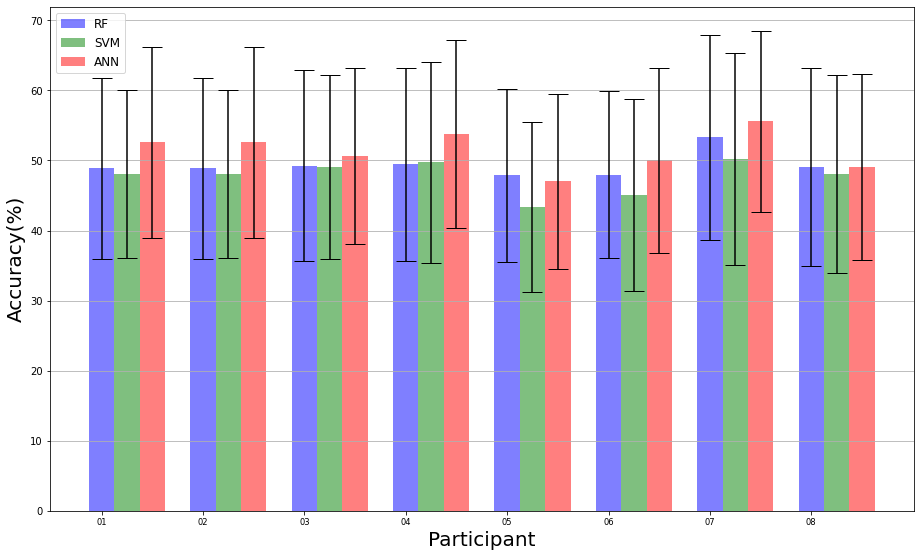

In [ ]:
plot(binary_all_words_mean_1_rf,binary_all_words_mean_1_svm,binary_all_words_mean_1_cnn,binary_all_words_std_1_rf,binary_all_words_std_1_svm,binary_all_words_std_1_cnn)


[49.68 49.68 53.49 52.86 48.32 49.79 52.58 49.35]
[57.3  57.3  51.44 52.05 47.   52.32 59.35 54.26]
[60.16 60.16 54.65 57.81 51.3  51.65 62.75 57.58]


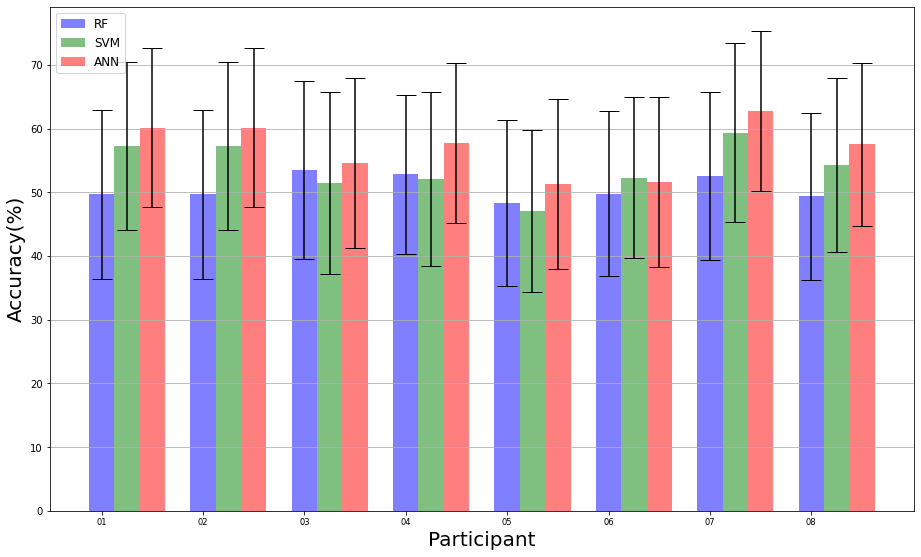

In [ ]:
plot(binary_all_words_mean_2_rf,binary_all_words_mean_2_svm,binary_all_words_mean_2_cnn,binary_all_words_std_2_rf,binary_all_words_std_2_svm,binary_all_words_std_2_cnn)


In [63]:
def plot_multi(mean1,mean2,mean3,std1,std2,std3):
  parts=["01","02","03","04","05","06","07","08"]
  X = np.arange(len(mean1))
  fig = plt.figure()
  plt.rcParams["figure.figsize"] = (12,7)
  ax = fig.add_axes([0,0,1,1])
  ax.set_ylabel('Accuracy(%)',fontsize=20)
  ax.set_xlabel('Participant',fontsize=20)
  plt.grid(axis = 'y')
  print(mean1)
  print(mean2)
  print(mean3)
  
  ax.bar(X + 0.00, mean1, yerr=std1, color = 'b', width = 0.25,align='center', alpha=0.5, ecolor='black', capsize=10)
  ax.bar(X + 0.25, mean2, yerr=std2, color = 'g', width = 0.25,align='center', alpha=0.5, ecolor='black', capsize=10)
  ax.bar(X + 0.50, mean3, yerr=std3, color = 'r', width = 0.25,align='center', alpha=0.5, ecolor='black', capsize=10)
  plt.xticks(range(len(parts)), parts, size='small')
  ax.legend(labels=['RF', 'SVM','ANN'],fontsize=12)
  plt.show()
  return

[7. 4. 6. 5. 8. 5. 5. 2.]
[9. 7. 6. 5. 4. 4. 9. 6.]
[12.  5.  5.  8.  5.  5. 11.  6.]


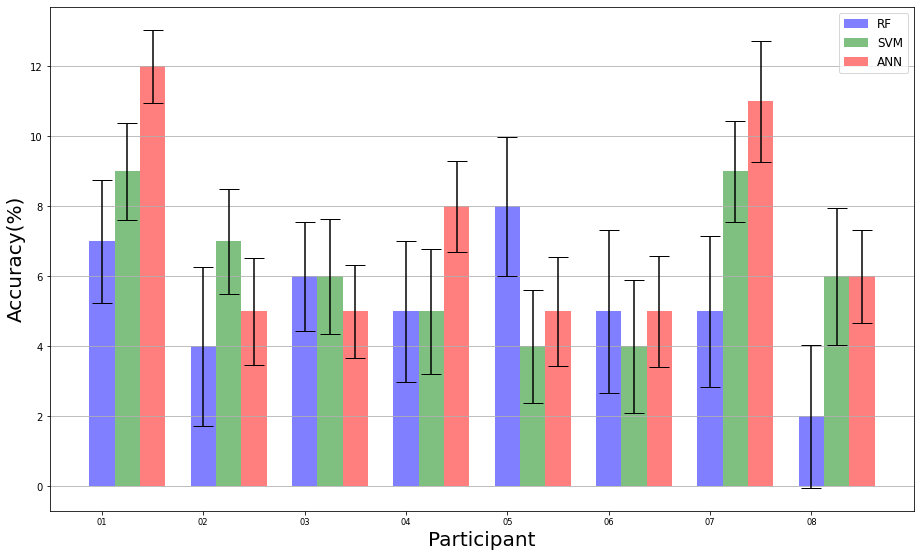

In [ ]:

plot_multi(multi_all_words_mean_2_rf,multi_all_words_mean_2_svm,multi_all_words_mean_2_cnn,multi_all_words_std_2_rf,multi_all_words_std_2_svm,multi_all_words_std_2_cnn)


[6. 4. 5. 5. 7. 5. 6. 2.]
[8. 2. 5. 4. 4. 4. 5. 2.]
[7. 3. 3. 7. 6. 5. 7. 4.]


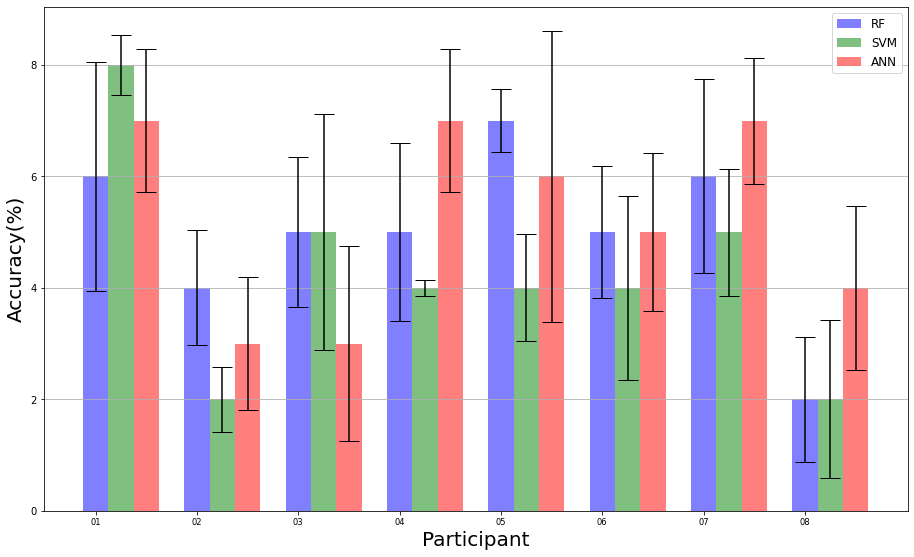

In [ ]:
plot_multi(multi_all_words_mean_1_rf,multi_all_words_mean_1_svm,multi_all_words_mean_1_cnn,multi_all_words_std_1_rf,multi_all_words_std_1_svm,multi_all_words_std_1_cnn)


[17.  8. 12. 13. 15. 18. 13.  8.]
[17. 15. 12.  8.  8. 15. 17.  7.]
[23. 12. 20. 15. 14. 17. 27. 18.]


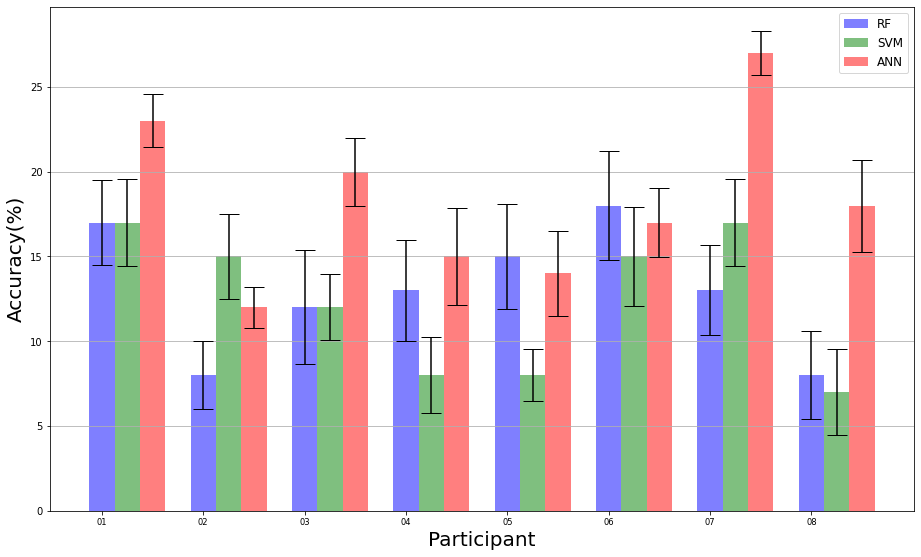

In [ ]:
plot_multi(multi_long_words_mean_2_rf,multi_long_words_mean_2_svm,multi_long_words_mean_2_cnn,multi_long_words_std_2_rf,multi_long_words_std_2_svm,multi_long_words_std_2_cnn)


[ 8.  8. 12.  4.  4. 11.  8. 11.]
[11. 11.  9. 10. 12.  8. 17. 13.]
[18. 10. 16. 16. 14. 10. 23. 13.]


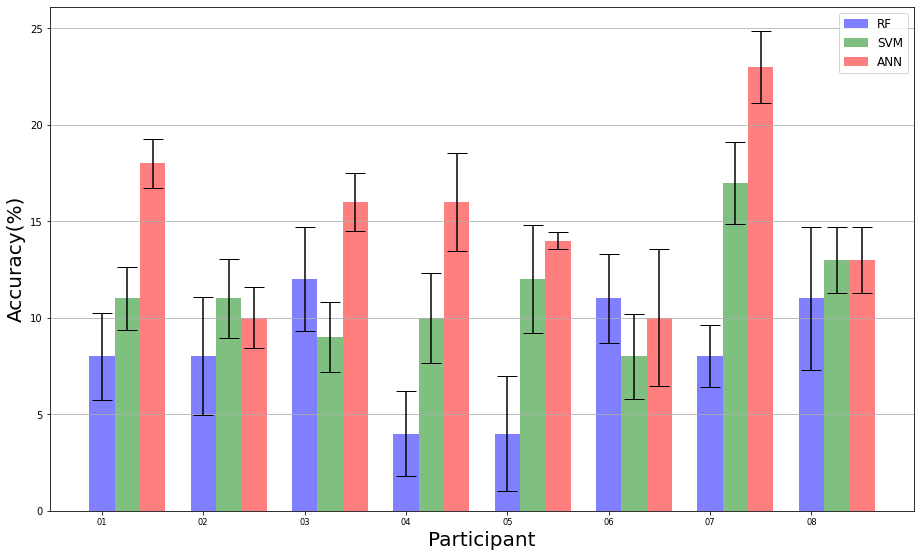

In [ ]:
plot_multi(multi_short_words_mean_2_rf,multi_short_words_mean_2_svm,multi_short_words_mean_2_cnn,multi_short_words_std_2_rf,multi_short_words_std_2_svm,multi_short_words_std_2_cnn)


[13. 12. 18. 10. 12. 13.  8.  8.]
[10.  7. 12.  5.  5.  7. 13. 10.]
[15. 12. 13. 18.  8. 12. 18.  8.]


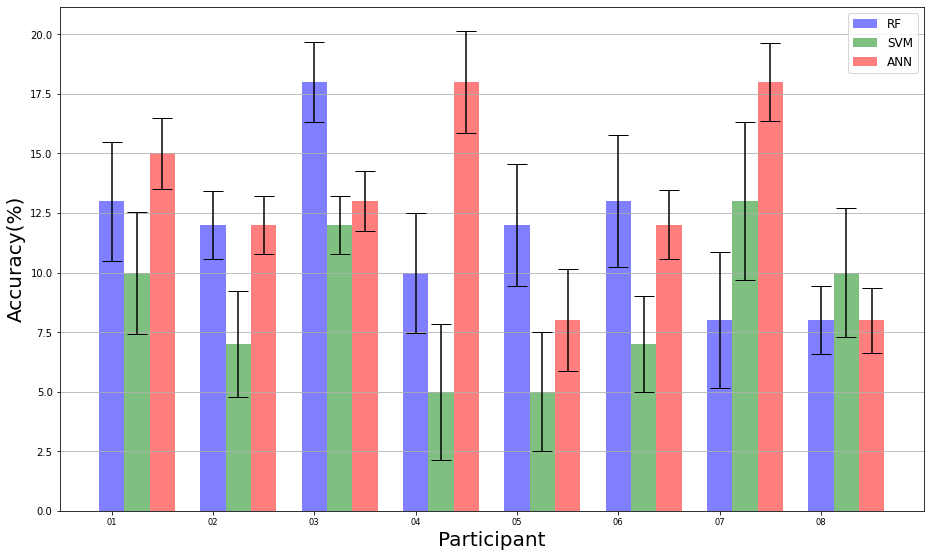

In [ ]:
plot_multi(multi_long_words_mean_1_rf,multi_long_words_mean_1_svm,multi_long_words_mean_1_cnn,multi_long_words_std_1_rf,multi_long_words_std_1_svm,multi_long_words_std_1_cnn)


[ 8. 12. 12.  6. 10. 10.  7. 10.]
[11.  7.  7. 10.  7.  6.  3.  6.]
[12. 12. 11. 12. 10.  7. 13. 10.]


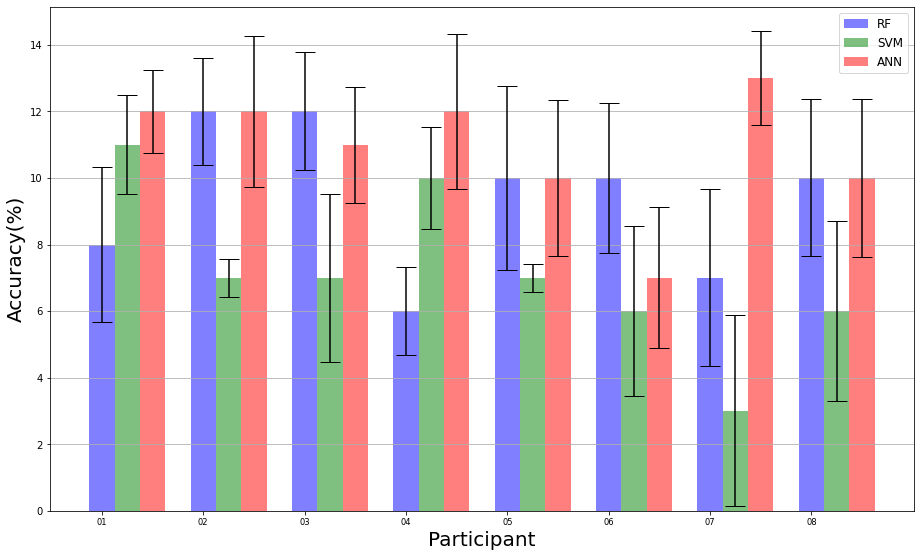

In [ ]:
plot_multi(multi_short_words_mean_1_rf,multi_short_words_mean_1_svm,multi_short_words_mean_1_cnn,multi_short_words_std_1_rf,multi_short_words_std_1_svm,multi_short_words_std_1_cnn)


In [56]:
def plot_dist(leven,word2vec,phonetic,neuro,acoustic):
  parts=["01","02","03","04","05","06","07","08"]
  X = np.arange(0,16,2)
  fig = plt.figure()
  plt.rcParams["figure.figsize"] = (14,7)
  ax = fig.add_axes([0,0,1,1])
  ax.set_ylabel('Score',fontsize=20)
  ax.set_xlabel('Participant',fontsize=20)
  plt.grid(axis = 'y')
  print(leven)
  print(word2vec)
  print(phonetic)
  print(neuro)
  print(acoustic)
  
  ax.bar(X + 0.00, leven, color = 'b', width = 0.25,align='center', alpha=0.5, ecolor='black', capsize=10)
  ax.bar(X + 0.25, word2vec, color = 'g', width = 0.25,align='center', alpha=0.5, ecolor='black', capsize=10)
  ax.bar(X + 0.50, phonetic, color = 'r', width = 0.25,align='center', alpha=0.5, ecolor='black', capsize=10)
  ax.bar(X + 0.75, neuro, color = 'black', width = 0.25,align='center', alpha=0.5, ecolor='black', capsize=10)
  ax.bar(X + 1, acoustic, color = 'orange', width = 0.25,align='center', alpha=0.5, ecolor='black', capsize=10)
  plt.xticks(X, parts, size='small')
  ax.legend(labels=['Levenshtein', 'Word2vec','Phonetic',"Neuro-Topological","Acoustic"],fontsize=12)
  plt.show()
  return

[ 5.    5.    3.    3.    2.89  3.44  2.   -2.33]
[ 3.67  3.67 -2.89  2.44 -1.89 -2.56 -3.22 -0.11]
[ 0.11  0.11  4.56  3.89 -4.33  1.44  0.67  0.89]
[-2.41 -2.41 -0.93  8.7   2.04 -1.3   0.37  1.67]
[ 1.44  1.44  3.67  5.11  2.89 -1.33  4.44  3.22]


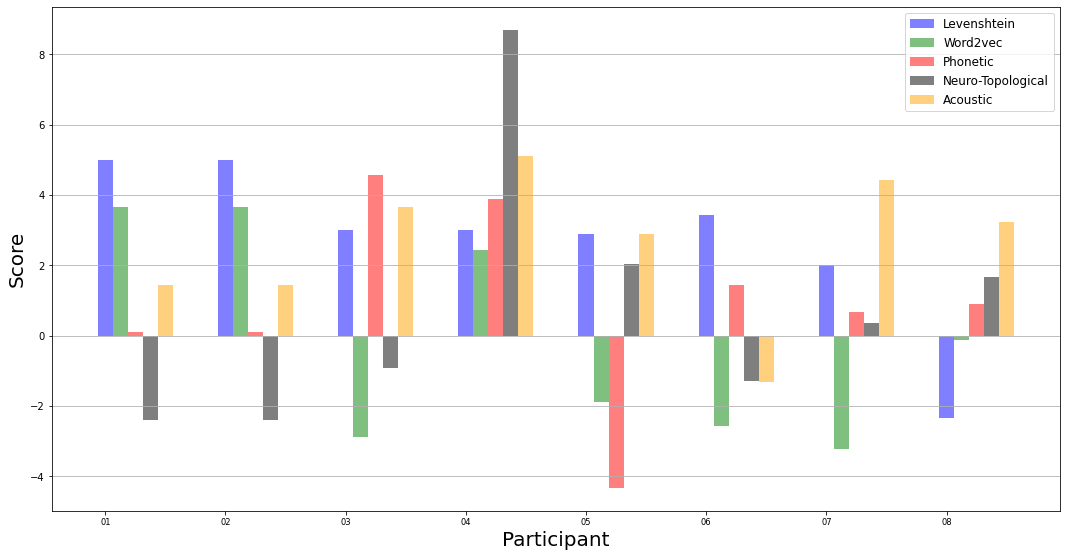

In [ ]:
plot_dist(leven_distance_2_ann,word2vec_distance_2_ann,phonetic_distance_2_ann,neuro_distance_2_ann,acoustic_distance_2_ann)

[12.   12.   12.99 11.79 12.74 12.5  12.8  13.23]
[ 1.11  1.11  2.67 -3.67 -2.78  2.55  3.78 -1.67]
[ 4.89  4.89 -1.56 -2.44 -5.78 -1.44 -1.    0.78]
[-1.22 -1.22  1.89 -2.33 -5.56 -0.11  4.22 -0.22]
[ 2.78  2.78 -0.74  1.48 -9.44 -0.   -4.44 -1.85]


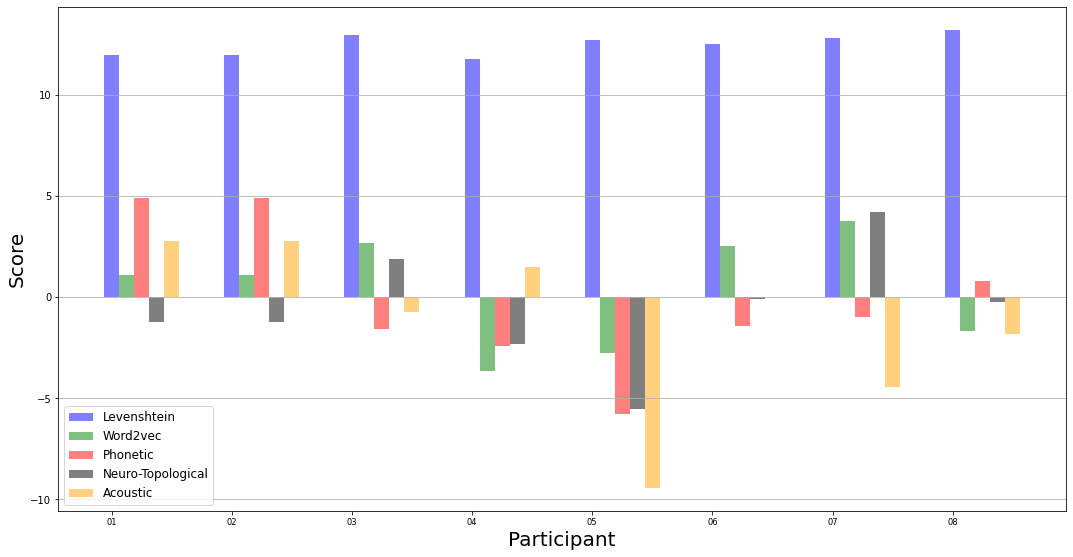

In [ ]:
plot_dist(leven_distance_2_rf,word2vec_distance_2_rf,phonetic_distance_2_rf,neuro_distance_2_rf,acoustic_distance_2_rf)

[-3.44 -3.44 -2.33  5.44  3.89 -3.11  2.56 -2.33]
[-3.67 -3.67  4.56  0.89 -4.67 -4.56 -2.56 -0.67]
[-1.22 -1.22 -3.11  2.33  7.89 -2.89  1.78 -0.11]
[-2.22 -2.22 -1.3  -4.44  5.55 -4.07 -3.52  4.44]
[-0.44 -0.44  2.67  1.78 -7.56  0.67  1.44  5.11]


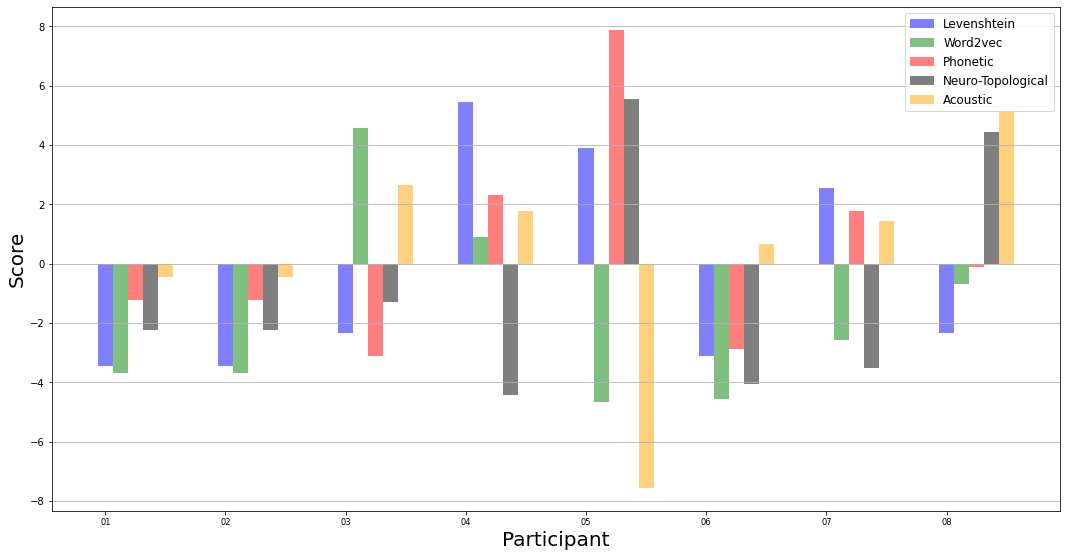

In [ ]:
plot_dist(leven_distance_2_svm,word2vec_distance_2_svm,phonetic_distance_2_svm,neuro_distance_2_svm,acoustic_distance_2_svm)

Inner speech plots

In [57]:
results_binary_1_list=[]
results_binary_2_list=[]
results_multi_l_list=[]
results_multi_2_list=[]

participants=["01","02","03","04","05","06","07","08"]
speech_types=["inner"]
for participant in participants:
  for speech_type in speech_types:
    arr=load(participant,speech_type)
    results_binary_1_list.append(arr[0])
    results_binary_2_list.append(arr[1])
    results_multi_l_list.append(arr[2])
    results_multi_2_list.append(arr[3])

results_binary_1_list=np.array(results_binary_1_list)
results_binary_2_list=np.array(results_binary_2_list)
results_multi_l_list=np.array(results_multi_l_list)
results_multi_2_list=np.array(results_multi_2_list)

In [58]:
binary_all_words_mean_2_rf=results_binary_2_list[:,0]
binary_all_words_mean_2_svm=results_binary_2_list[:,2]
binary_all_words_mean_2_cnn=results_binary_2_list[:,4]

binary_all_words_std_2_rf=results_binary_2_list[:,1]
binary_all_words_std_2_svm=results_binary_2_list[:,3]
binary_all_words_std_2_cnn=results_binary_2_list[:,5]



multi_all_words_mean_2_rf=results_multi_2_list[:,0]*100
multi_all_words_mean_2_svm=results_multi_2_list[:,1]*100
multi_all_words_mean_2_cnn=results_multi_2_list[:,2]*100

multi_all_words_std_2_rf=[1.22, 2.45, 1.34, 1.51, 1.29, 2.13, 2.42, 2.14]
multi_all_words_std_2_svm=[1.14, 1.28, 1.45, 1.89, 1.22, 1.43, 1.56, 1.41]
multi_all_words_std_2_cnn=[1.21, 1.35, 1.43, 1.12, 1.65, 1.18, 1.34, 1.39]

multi_long_words_mean_2_rf=results_multi_2_list[:,3]*100
multi_long_words_mean_2_svm=results_multi_2_list[:,4]*100
multi_long_words_mean_2_cnn=results_multi_2_list[:,5]*100

multi_long_words_std_2_rf=[2.5, 2.0, 3.36, 2.97, 3.07, 3.23, 2.65, 2.58]
multi_long_words_std_2_svm=[2.55, 2.51, 1.95, 2.25, 1.54, 2.91, 2.59, 2.55]
multi_long_words_std_2_cnn=[1.56, 1.21, 2.0, 2.86, 2.51, 2.02, 1.31, 2.71]

multi_short_words_mean_2_rf=results_multi_2_list[:,6]*100
multi_short_words_mean_2_svm=results_multi_2_list[:,7]*100
multi_short_words_mean_2_cnn=results_multi_2_list[:,8]*100

multi_short_words_std_2_rf=[2.25, 3.06, 2.7, 2.21, 2.99, 2.31, 1.61, 3.68]
multi_short_words_std_2_svm=[1.61, 2.06, 1.8, 2.32, 2.79, 2.19, 2.12, 1.73]
multi_short_words_std_2_cnn=[1.28, 1.57, 1.52, 2.52, 0.42, 3.55, 1.87, 1.7]


[51.07 51.07 52.46 54.11 50.6  48.6  51.56 49.46]
[52.6  49.86 54.88 51.51 48.75 56.44 60.19 56.35]
[58.77 52.35 58.39 55.74 53.05 55.19 63.65 57.46]


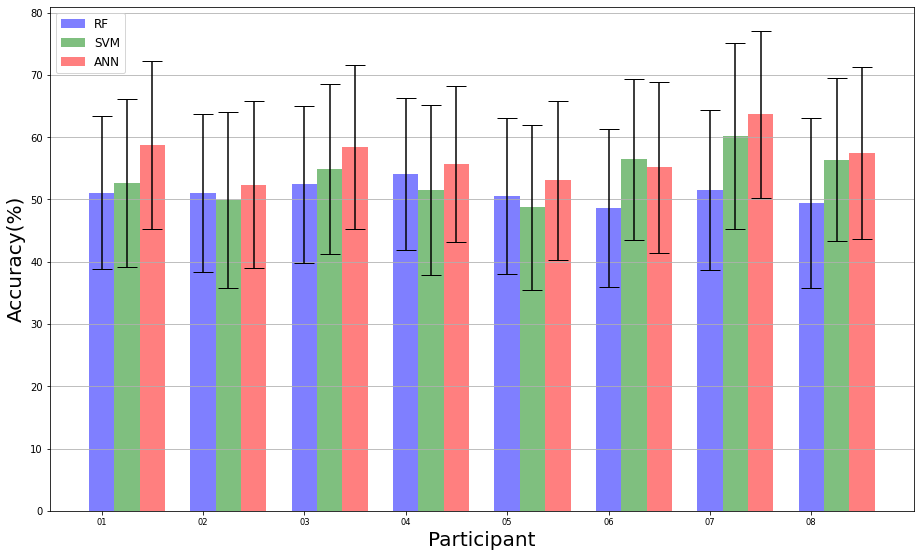

In [60]:
plot(binary_all_words_mean_2_rf,binary_all_words_mean_2_svm,binary_all_words_mean_2_cnn,binary_all_words_std_2_rf,binary_all_words_std_2_svm,binary_all_words_std_2_cnn)


[ 5.  5.  9.  5.  5.  6.  3. 10.]
[ 7.  5.  7.  9.  5.  6. 11.  8.]
[ 7.  7.  8.  3.  7.  9. 13.  9.]


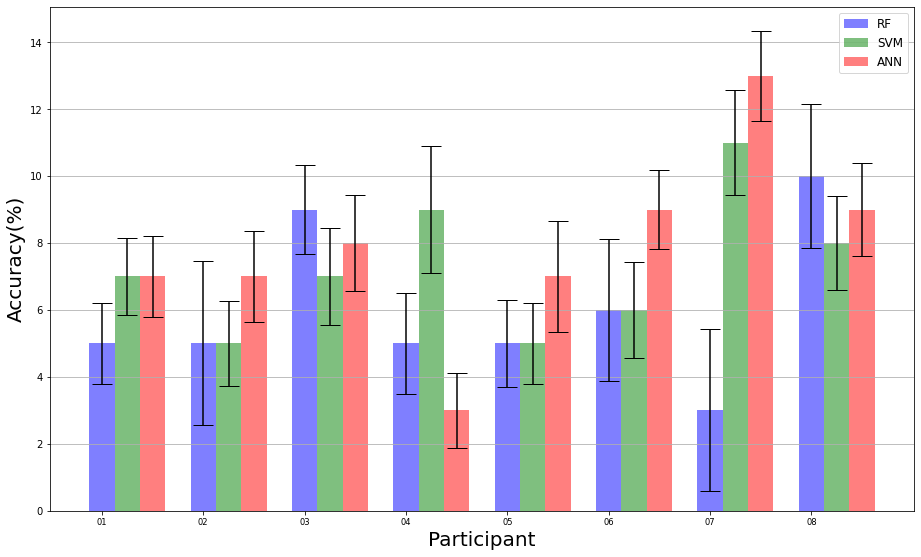

In [64]:

plot_multi(multi_all_words_mean_2_rf,multi_all_words_mean_2_svm,multi_all_words_mean_2_cnn,multi_all_words_std_2_rf,multi_all_words_std_2_svm,multi_all_words_std_2_cnn)


[12. 20. 10. 15. 17. 15. 10. 10.]
[10. 15. 18. 12. 13. 18. 15. 17.]
[30. 17. 18. 15. 17. 18. 27. 12.]


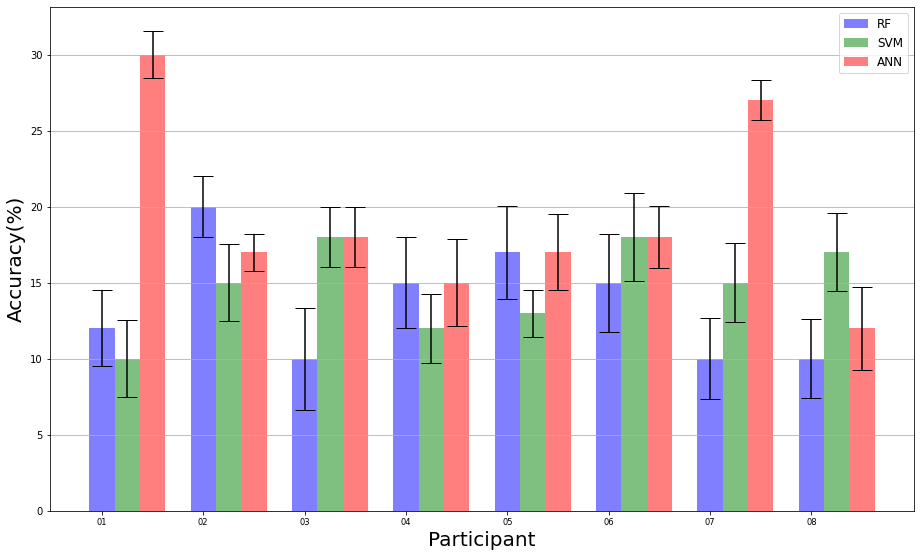

In [65]:
plot_multi(multi_long_words_mean_2_rf,multi_long_words_mean_2_svm,multi_long_words_mean_2_cnn,multi_long_words_std_2_rf,multi_long_words_std_2_svm,multi_long_words_std_2_cnn)


[ 8. 10. 12.  8.  7.  7.  3.  4.]
[12. 13.  9. 14. 11. 11. 13. 16.]
[14.  8. 13. 11. 10.  8. 16. 11.]


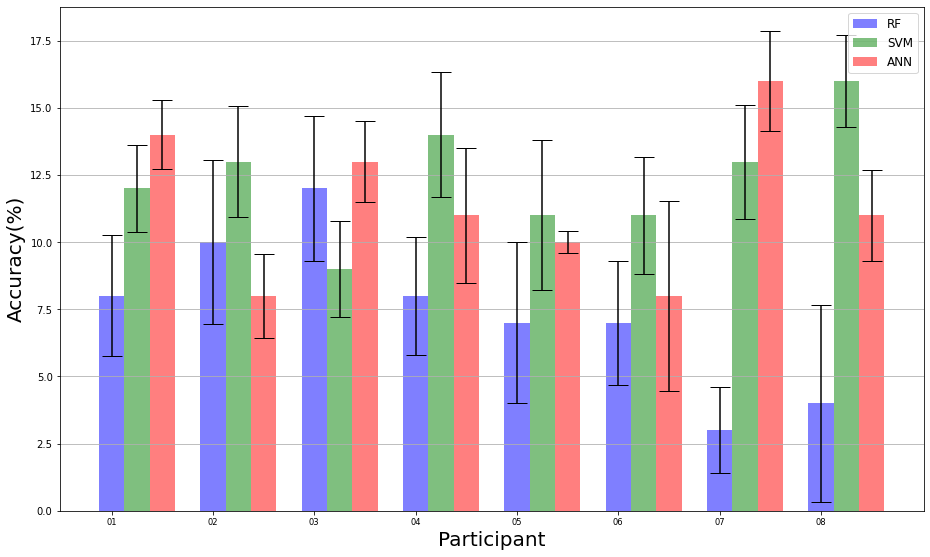

In [66]:
plot_multi(multi_short_words_mean_2_rf,multi_short_words_mean_2_svm,multi_short_words_mean_2_cnn,multi_short_words_std_2_rf,multi_short_words_std_2_svm,multi_short_words_std_2_cnn)
